# Генерация систем непрерывных и дискретных случайных величин

In [1]:
import math
import random as r
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

## Формирование двумерной НСВ
### Генерация значений

In [2]:
# 7th variant function (edited)
fxy = lambda x, y: math.cos(x - y) / 2

# function params
a = 0
b = math.pi / 2
fxy_max = 0.5

n = 1000

x_l, y_l = [], []
i = 0
while i < n:
    x_, y_ = (a + r.random() * (b - a) for _ in range(2))
    z_ = r.random() * fxy_max
    if fxy(x_, y_) > z_:
        x_l.append(x_)
        y_l.append(y_)
        i += 1

### Статистические исследования
#### Мат. ожидания и дисперии

In [3]:
M_f = lambda l: sum(l) / n
D_f = lambda l: sum(e ** 2 for e in l) / n - M_f(l) ** 2

print('M[x] =', M_f(x_l), 'D[x] =', D_f(x_l))
print('M[y] =', M_f(y_l), 'D[y] =', D_f(y_l))

M[x] = 0.7939934565025007 D[x] = 0.1868372316129785
M[y] = 0.789922351559428 D[y] = 0.1875038052641005


#### Медианы и коэфициенты корреляции

In [4]:
print('Me[x] =', np.median(x_l))
print('Me[y] =', np.median(y_l))

print('K[xy] =', st.pearsonr(x_l, y_l)[0])

Me[x] = 0.8088920670746278
Me[y] = 0.7884713151453961
K[xy] = 0.2375542934013709


#### Гистограммы

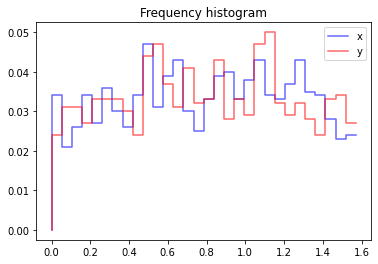

In [5]:
K = 30
d = (b - a) / K
di_l = [i * d for i in range(K + 1)]

def draw_plot(l, **kwargs):
    v_l = [
        len(list(filter(lambda v: di - d <= v < di, l))) / n
        for di in di_l
    ]
    plt.plot(di_l, v_l, drawstyle='steps-pre', alpha=0.6, **kwargs)
    plt.legend()


draw_plot(x_l, label='x', color='b')
draw_plot(y_l, label='y', color='r')

plt.title(f'Frequency histogram')
plt.show()

#### График функции

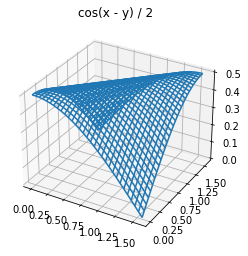

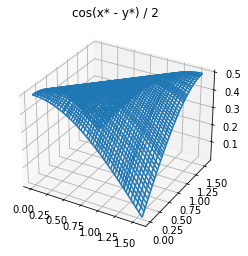

In [16]:
def draw_3d_plot(x_l, y_l, title=None):
    x, y = np.meshgrid(x_l, y_l)
    z = np.cos(x - y) / 2
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(x, y, z)
    ax.set_title(title)
    plt.show()
    
draw_3d_plot(di_l, di_l, 'cos(x - y) / 2')
draw_3d_plot(sorted(x_l), sorted(y_l), 'cos(x* - y*) / 2')